# Embeddings

In [2]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import InputEmbeddings  # Notre implémentation du papier
from model import PositionalEncoding

Ce notebook explore les embeddings utilisés dans l'architecture Transformer:
1. Token Embeddings: représentations vectorielles des mots
2. Positional Encoding: information sur la position des tokens dans la séquence

Nous allons visualiser chaque composante et comprendre pourquoi ces choix techniques ont été faits
dans le papier "Attention Is All You Need".

In [3]:
# Définissons un petit vocabulaire d'exemple
vocab = ["Je", "vais", "à", "la", "l", "maison", "école", "en", "légende", ".", "<PAD>"]
vocab_size = len(vocab)
d_model = 8  # Gardons une dimension réduite pour la visualisation

In [4]:
# Création des dictionnaires de conversion
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

Les embeddings de tokens transforment les indices de tokens (entiers) en vecteurs denses.
- Chaque token est représenté par un vecteur de dimension d_model
- Dans le Transformer original: d_model = 512
- La multiplication par √d_model aide à maintenir des gradients appropriés

In [5]:
# Initialisation de la couche d'embedding
embedding_layer = InputEmbeddings(d_model, vocab_size)

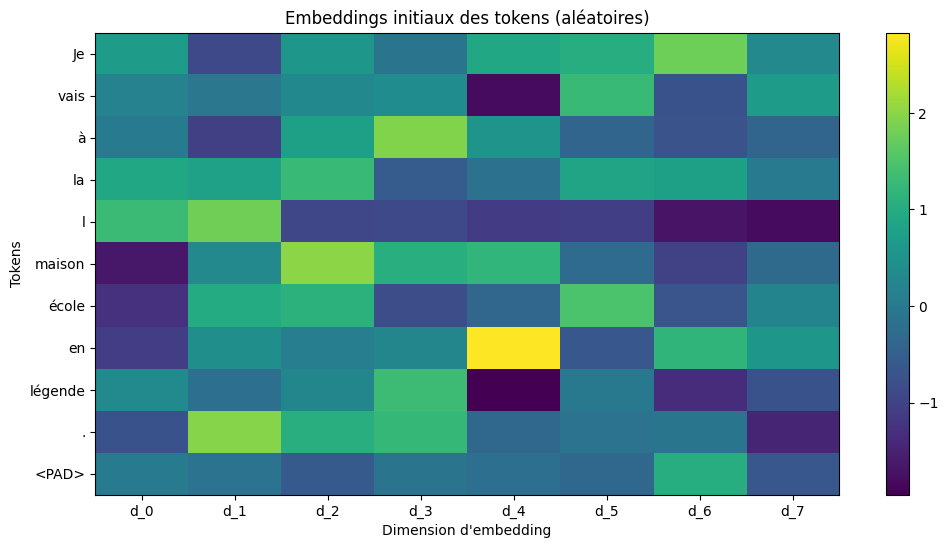

In [6]:
# Visualisation des embeddings initiaux (aléatoires)
plt.figure(figsize=(12, 6))
plt.imshow(embedding_layer.embedding.weight.detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Embeddings initiaux des tokens (aléatoires)")
plt.xlabel("Dimension d'embedding")
plt.ylabel("Tokens")
plt.yticks(range(len(vocab)), vocab)
plt.xticks(range(d_model), [f'd_{i}' for i in range(d_model)])
plt.show()

## Les embeddings initiaux : transformation des mots en vecteurs

```python
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)
```

Les embeddings sont la première étape cruciale du Transformer. Leur rôle est de transformer chaque mot (représenté par un indice entier) en un vecteur dense de dimension `d_model`.

**Comment ça marche ?**

1. **La couche d'embedding** (`nn.Embedding`)
   - C'est une simple table de correspondance (lookup table)
   - Pour un vocabulaire de taille `vocab_size`, elle crée une matrice de taille `vocab_size × d_model`
   - Chaque ligne de cette matrice représente un mot du vocabulaire

2. **Initialisation aléatoire**
   - Au début, les vecteurs sont initialisés aléatoirement
   - C'est comme donner une "feuille blanche" au modèle
   - Ces valeurs vont s'ajuster pendant l'entraînement pour capturer le sens des mots

3. **Le forward et l'apprentissage**
   - La fonction `forward` récupère simplement les vecteurs correspondant aux indices des mots
   - La multiplication par `sqrt(d_model)` est un facteur d'échelle qui aide à la stabilité
   - Pendant l'entraînement, ces embeddings seront mis à jour par rétropropagation

**Exemple concret**

Si on a les mots "chat" et "chien" :
- Au début : vecteurs aléatoires sans relation
- Après entraînement : vecteurs probablement proches car ces mots apparaissent dans des contextes similaires

Cette représentation vectorielle permet au Transformer de traiter les mots mathématiquement et de capturer leurs relations sémantiques.

In [7]:
# Exploration de quelques exemples
token_indices = torch.tensor([word2idx["Je"], word2idx["vais"], word2idx["à"]])
token_embs = embedding_layer(token_indices)

print(f"Dimension des embeddings: {token_embs.shape}")
print(f"Embedding pour 'Je': {token_embs[0]}")
print(f"Note: Les valeurs sont multipliées par √d_model = {math.sqrt(d_model)}")

Dimension des embeddings: torch.Size([3, 8])
Embedding pour 'Je': tensor([ 1.9399, -2.5293,  1.6158, -0.3076,  2.5629,  2.9269,  5.0038,  0.8713],
       grad_fn=<SelectBackward0>)
Note: Les valeurs sont multipliées par √d_model = 2.8284271247461903


## Positional Encoding

Problème fondamental: les Transformers traitent tous les tokens en parallèle!

Contrairement aux RNNs qui traitent les tokens séquentiellement, les Transformers n'ont pas de notion
intrinsèque d'ordre. Sans information de position, ces deux phrases seraient identiques pour le modèle:
- "Le chat mange la souris"
- "La souris mange le chat"

Solution: ajouter explicitement l'information de position aux embeddings.

In [8]:
# Créons deux phrases d'exemple
sentences = [
    ["Je", "vais", "à", "la", "maison", "en", "légende", "."],
    ["Je", "vais", "à", "l", "école", "."]
]

In [9]:
# Conversion en indices
def sentences_to_tensor(sentences):
    max_len = max(len(s) for s in sentences)
    indices = []
    for sent in sentences:
        # Padding à droite avec <PAD>
        padded = sent + ["<PAD>"] * (max_len - len(sent))
        indices.append([word2idx[w] for w in padded])
    return torch.tensor(indices), max_len

In [10]:
# Création du tenseur d'entrée
input_tensor, seq_len = sentences_to_tensor(sentences)
print("Phrases converties en indices:")
print(input_tensor)

Phrases converties en indices:
tensor([[ 0,  1,  2,  3,  5,  7,  8,  9],
        [ 0,  1,  2,  4,  6,  9, 10, 10]])


Problème : Les transformers n'ont pas de notion d'ordre séquentiel (contrairement aux RNNs) car ils traitent tous les tokens en parallèle.

Solution : Ajouter un "positional encoding" aux embeddings pour injecter l'information de position

Formule utilisée : Fonctions sinus pour les dimensions paires et cosinus pour les dimensions impaires.

$$
PE(pos, 2i) = sin(pos / 10000^{2i/d_{model}})
$$
$$
PE(pos, 2i+1) = cos(pos / 10000^{2i/d_{model}})
$$

où:
- pos est la position dans la séquence
- i est l'indice de la dimension
- d_model est la dimension du modèle

Propriétés importantes:
1. Les valeurs sont entre -1 et 1
2. Chaque position a un vecteur unique
3. Pour tout offset k fixe, PE(pos+k) peut être exprimé comme fonction linéaire de PE(pos)
4. Permet d'extrapoler à des longueurs de séquences non vues pendant l'entraînement

Alternative: on aurait pu apprendre les embeddings de position, mais les auteurs ont trouvé que les deux approches donnaient des résultats similaires, et l'encodage sinusoïdal
permet une meilleure généralisation.



Examinons l'implémentation dans notre modèle:

```python
class PositionalEncoding(nn.Module):
    def init(self, d_model: int, seq_len: int, dropout: float):
        super().init()

        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) -(math.log(10000.0) / d_model))

        # On applique sin aux indices pairs et cos aux indices impairs
        pe[:, 0::2] = torch.sin(position div_term)
        pe[:, 1::2] = torch.cos(position div_term)

        # On ajoute la dimension batch
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)
```

Points importants:
- div_term calcule efficacement 10000^(2i/d_model)
- register_buffer sauvegarde pe sans l'ajouter aux paramètres à optimiser
- Dans forward(), on ajoute simplement le PE aux embeddings

In [11]:
# Initialisation du positional encoding
positional_encoding = PositionalEncoding(d_model, seq_len=seq_len, dropout=0.1)

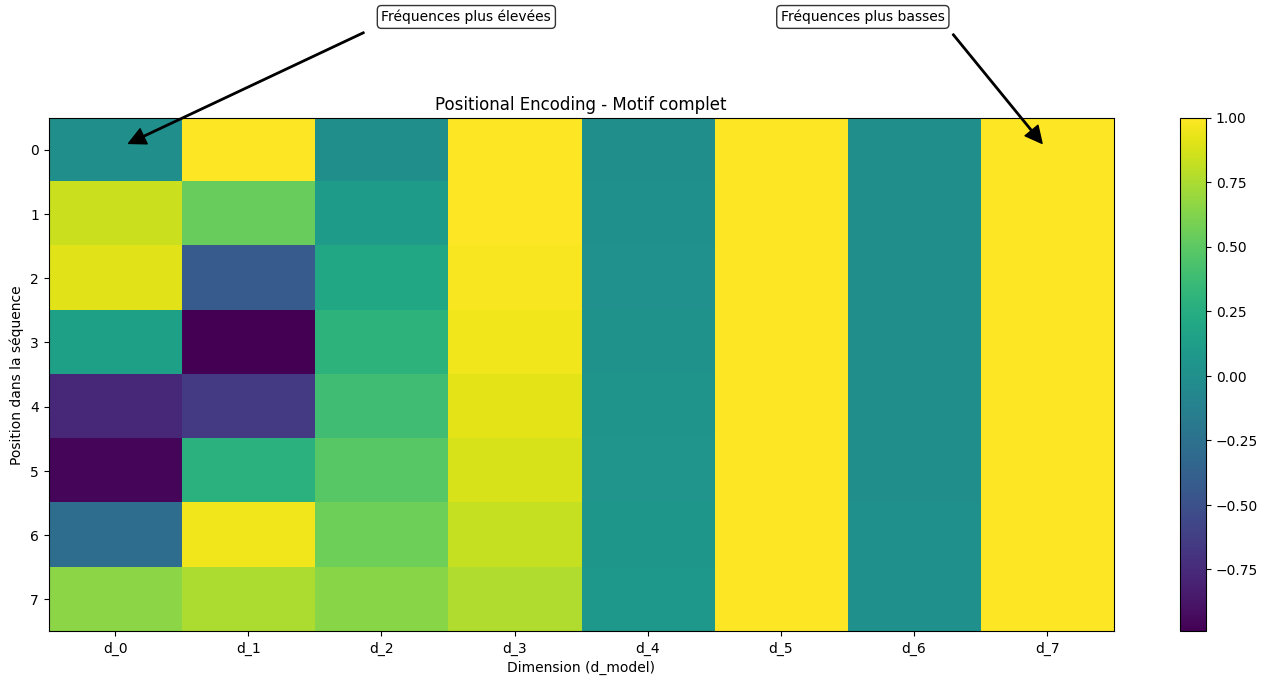

In [12]:
# Visualisation du motif complet
plt.figure(figsize=(14, 7))
pos_enc = positional_encoding.pe[0, :seq_len, :].detach().numpy()
plt.imshow(pos_enc, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Positional Encoding - Motif complet")
plt.xlabel("Dimension (d_model)")
plt.ylabel("Position dans la séquence")
plt.xticks(range(d_model), [f'd_{i}' for i in range(d_model)])
plt.yticks(range(seq_len), [i for i in range(seq_len)])

# Annotations
plt.annotate("Fréquences plus basses", 
            xy=(d_model-1, 0),  # point de départ de la flèche
            xytext=(d_model-3, -2),  # position du texte
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.annotate("Fréquences plus élevées", 
            xy=(0, 0),  # point de départ de la flèche
            xytext=(2, -2),  # position du texte
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.tight_layout()
plt.show()

### Comprendre le motif du Positional Encoding

Le motif que nous observons s'explique par les différentes fréquences utilisées dans l'encodage :

- **Dimensions basses (gauche)** : Les fréquences sont plus élevées (division par un petit nombre), ce qui produit des variations plus rapides des valeurs de sinus et cosinus. C'est pourquoi on voit beaucoup de changements de couleurs.

- **Dimensions hautes (droite)** : Les fréquences sont très basses (division par un grand nombre), ce qui fait que :
  - Les dimensions paires (sin) restent proches de 0
  - Les dimensions impaires (cos) restent proches de 1

Cette structure permet au modèle de capturer des dépendances à différentes échelles :
- Les dimensions basses capturent les relations de position fines
- Les dimensions hautes capturent les relations de position plus grossières

C'est un peu comme avoir une règle graduée avec différentes précisions : millimètres d'un côté, centimètres de l'autre.

Le graphique ci-dessous montre cette dynamique, plus la dimension est élevée, plus la fréquence est basse.

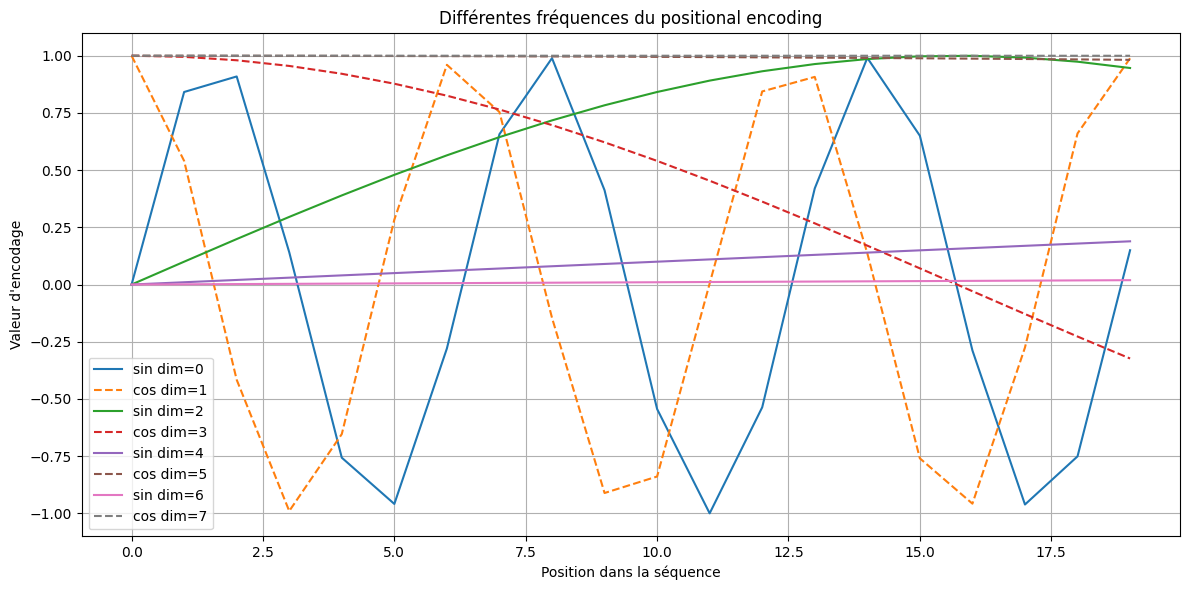

In [13]:
# Visualisation des différentes fréquences
plt.figure(figsize=(12, 6))
pos = np.arange(20)  # 20 positions différentes
for i in range(d_model//2):
    # Calcul des valeurs sinus et cosinus
    wave_length = 10000 ** (2 * i / d_model)
    sin_values = np.sin(pos / wave_length)
    cos_values = np.cos(pos / wave_length)
    
    plt.plot(pos, sin_values, label=f'sin dim={2*i}', linestyle='-')
    plt.plot(pos, cos_values, label=f'cos dim={2*i+1}', linestyle='--')

plt.title("Différentes fréquences du positional encoding")
plt.xlabel("Position dans la séquence")
plt.ylabel("Valeur d'encodage")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Pourquoi cette approche ?

**Approche RNN (Réseau de Neurones Récurrent)**
- Pour chaque mot, le modèle :
  - Regarde le mot actuel
  - Utilise sa "mémoire" des mots précédents
  - Met à jour cette mémoire
- ➡️ Comme quelqu'un qui lit en gardant le contexte en tête
- 🚫 Problème : plus la phrase est longue, plus il est difficile de maintenir un contexte précis

**Approche Transformer**
- Voit tous les mots simultanément
- Peut directement connecter n'importe quels mots entre eux
- ➡️ Comme avoir une vue d'ensemble qui permet de relier directement les éléments pertinents
- ✅ Mais pour cela, il faut que le modèle sache où se trouve chaque mot !

Le positional encoding, avec ses différentes fréquences, donne cette information de position :
- Les oscillations rapides (hautes fréquences) : distinguent les positions proches
- Les oscillations lentes (basses fréquences) : distinguent les positions éloignées

C'est un peu comme avoir une règle graduée avec différentes précisions qui permet au modèle de mesurer facilement les distances entre les mots, qu'ils soient proches ou éloignés.

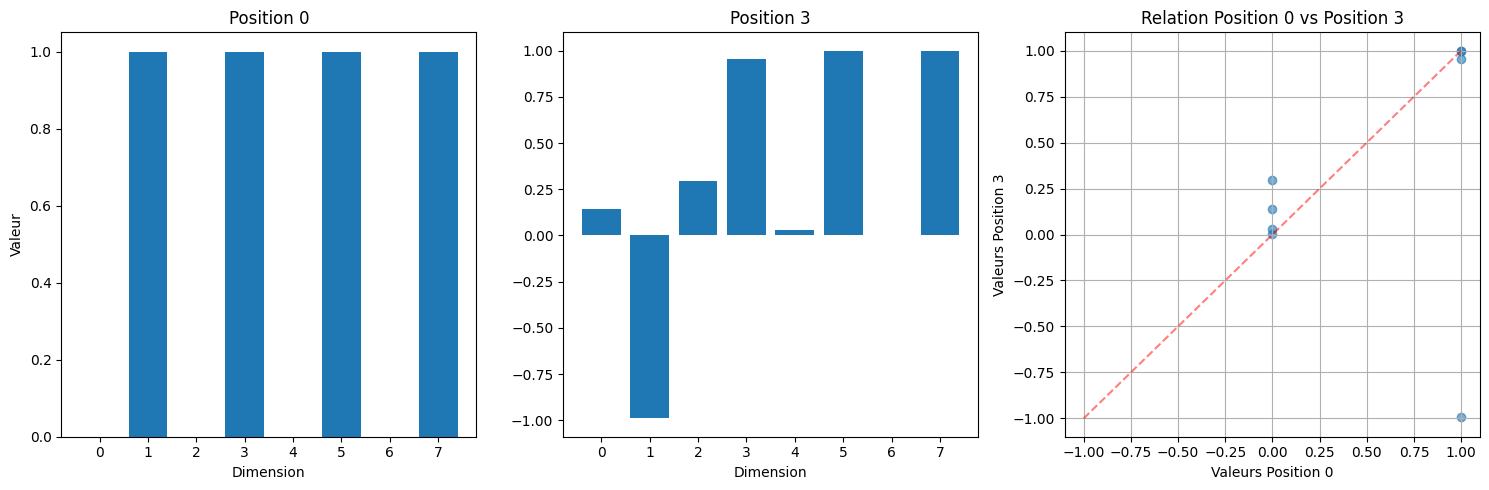

In [15]:
# Visualisation plus claire de la relation entre positions
plt.figure(figsize=(15, 5))

# 1. Position originale
plt.subplot(1, 3, 1)
pos0 = positional_encoding.pe[0, 0, :].detach().numpy()
plt.bar(range(d_model), pos0)
plt.title("Position 0")
plt.xlabel("Dimension")
plt.ylabel("Valeur")

# 2. Position décalée
plt.subplot(1, 3, 2)
pos3 = positional_encoding.pe[0, 3, :].detach().numpy()
plt.bar(range(d_model), pos3)
plt.title("Position 3")
plt.xlabel("Dimension")

# 3. Relation entre les deux
plt.subplot(1, 3, 3)
plt.scatter(pos0, pos3, alpha=0.6)
plt.plot([-1, 1], [-1, 1], 'r--', alpha=0.5)  # ligne de référence
plt.title("Relation Position 0 vs Position 3")
plt.xlabel("Valeurs Position 0")
plt.ylabel("Valeurs Position 3")
plt.grid(True)

plt.tight_layout()
plt.show()

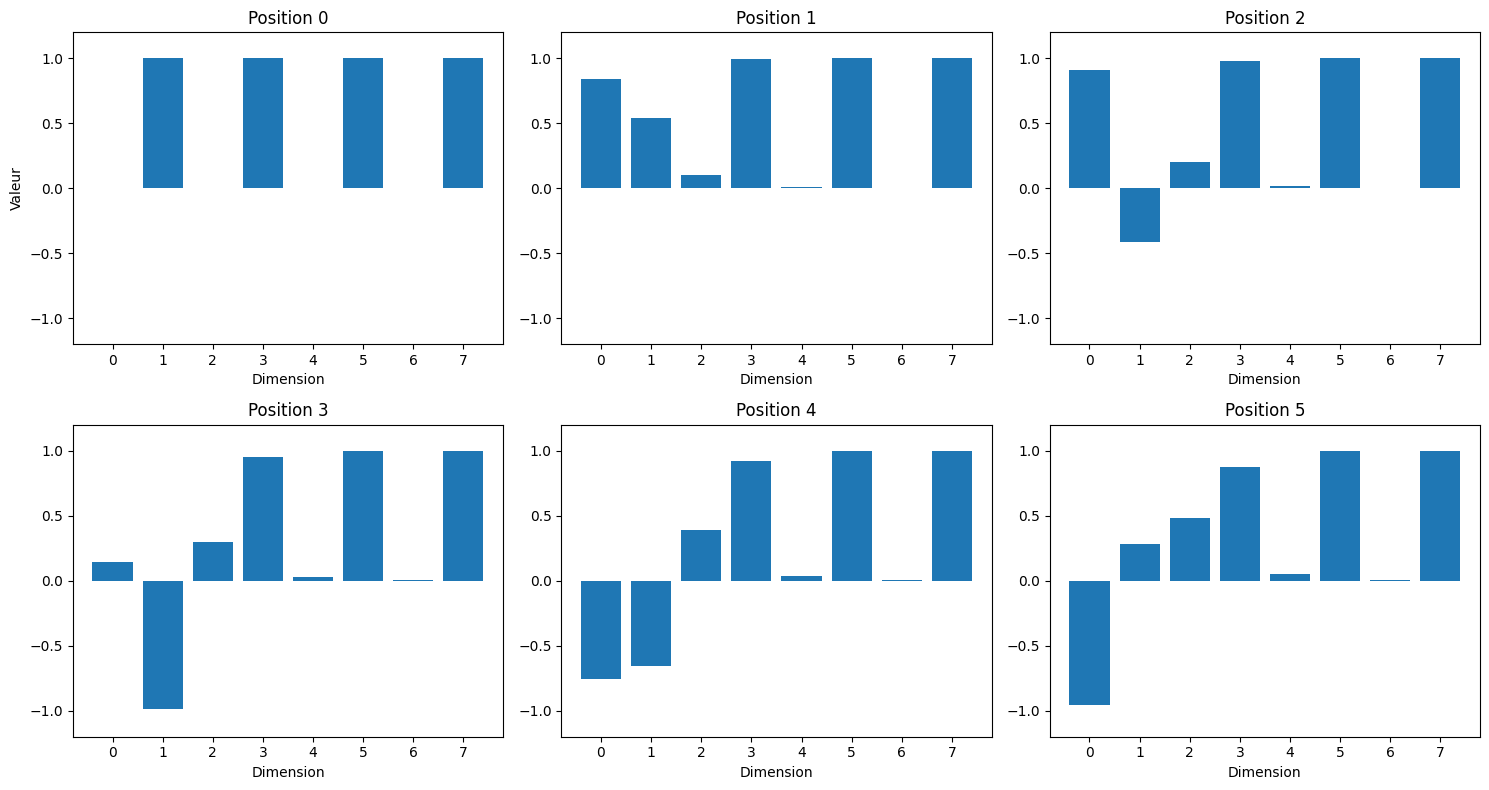

In [20]:
# Visualisation de l'évolution des valeurs sur plusieurs positions
plt.figure(figsize=(15, 8))
positions = [0, 1, 2, 3, 4, 5]  # On regarde les 6 premières positions

for i, pos in enumerate(positions):
    plt.subplot(2, 3, i+1)
    values = positional_encoding.pe[0, pos, :].detach().numpy()
    plt.bar(range(d_model), values)
    plt.title(f"Position {pos}")
    plt.xlabel("Dimension")
    plt.ylabel("Valeur" if i == 0 else "")
    plt.ylim(-1.2, 1.2)  # Fixe l'échelle pour toutes les visualisations

plt.tight_layout()
plt.show()

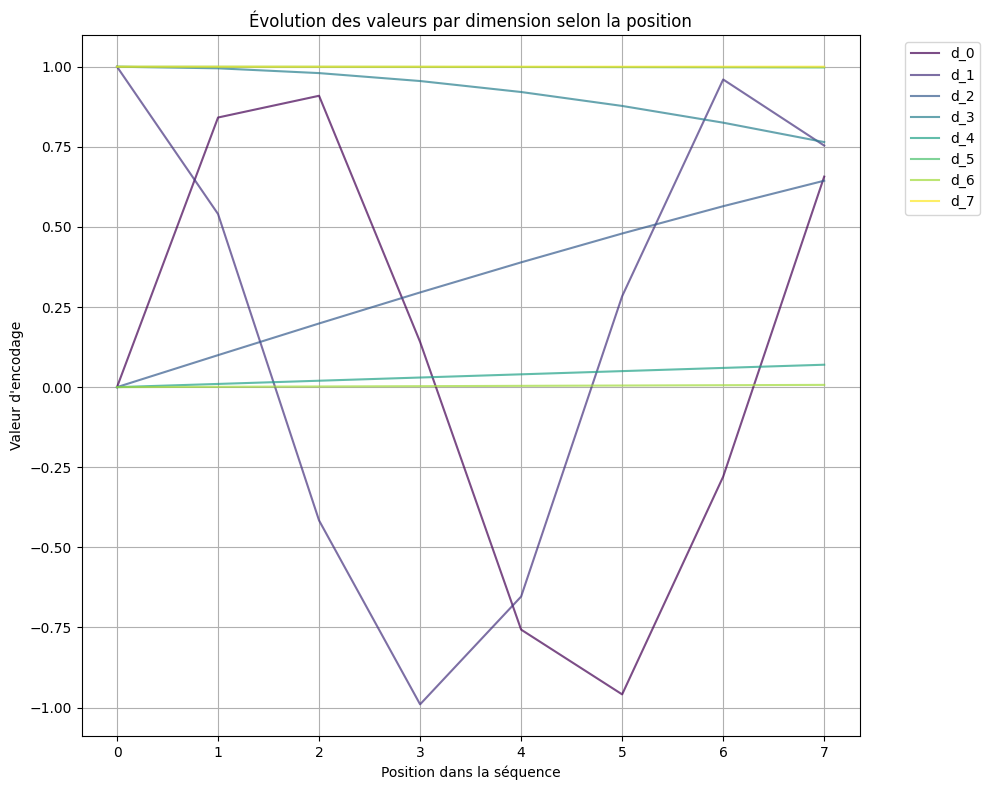

In [23]:
# Visualisation de l'évolution sur un repère 2D
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, d_model))  # Une couleur par dimension
max_pos = 8  # On limite aux 8 premières positions

for dim in range(d_model):
    values = [positional_encoding.pe[0, pos, dim].item() for pos in range(max_pos)]
    plt.plot(range(max_pos), values, label=f'd_{dim}', color=colors[dim], alpha=0.7)

plt.title("Évolution des valeurs par dimension selon la position")
plt.xlabel("Position dans la séquence")
plt.ylabel("Valeur d'encodage")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Les histogrammes** montrent les valeurs pour chaque dimension à une position donnée :
- À la position 0 : dimensions paires (sin) = 0, dimensions impaires (cos) = 1
- Au fur et à mesure que la position augmente, les valeurs évoluent différemment selon les dimensions
- Chaque position obtient ainsi un "code-barres" unique qui la caractérise

C'est comme un orchestre où chaque dimension joue sa note à son propre rythme, créant une mélodie unique pour chaque position !

In [16]:
# Obtention des embeddings
token_embeddings = embedding_layer(input_tensor)
pos_encodings = positional_encoding.pe[:, :token_embeddings.shape[1], :]
final_embeddings = token_embeddings + pos_encodings

print("Dimensions:")
print(f"Token embeddings: {token_embeddings.shape}")
print(f"Positional encodings: {pos_encodings.shape}")
print(f"Final embeddings: {final_embeddings.shape}")

Dimensions:
Token embeddings: torch.Size([2, 8, 8])
Positional encodings: torch.Size([1, 8, 8])
Final embeddings: torch.Size([2, 8, 8])


Dans le Transformer, les embeddings finaux sont la somme de:
- Token embeddings: représentation sémantique du token
- Positional encodings: information sur la position

Cette somme permet au modèle d'apprendre à la fois:
- Le sens des mots individuels
- Les relations entre mots basées sur leur position

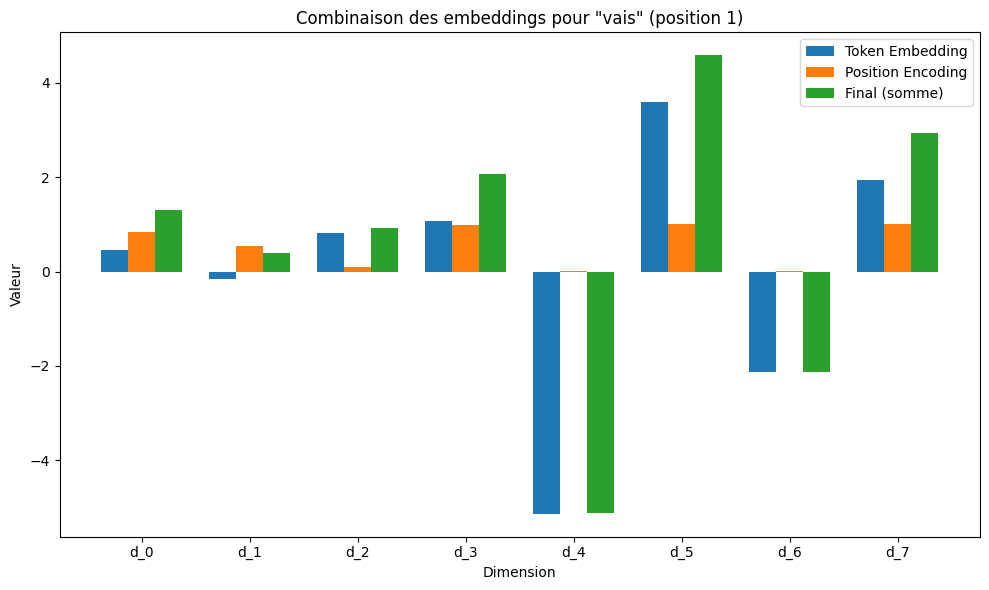

In [22]:
# Visualisation de la combinaison pour un token spécifique
token_idx = 1  # "vais" dans la première phrase
plt.figure(figsize=(10, 6))
x = np.arange(d_model)
width = 0.25

embeds = token_embeddings[0, token_idx, :].detach().numpy()
pos_enc = pos_encodings[0, token_idx, :].detach().numpy()
final = final_embeddings[0, token_idx, :].detach().numpy()

plt.bar(x - width, embeds, width, label='Token Embedding')
plt.bar(x, pos_enc, width, label='Position Encoding')
plt.bar(x + width, final, width, label='Final (somme)')
plt.xlabel('Dimension')
plt.ylabel('Valeur')
plt.title(f'Combinaison des embeddings pour "{sentences[0][token_idx]}" (position {token_idx})')
plt.legend()
plt.xticks(range(d_model), [f'd_{i}' for i in range(d_model)])
plt.tight_layout()
plt.show()

Visualisons maintenant les embeddings finaux pour nos phrases d'exemple.
Cela nous permet de voir comment chaque token est représenté dans l'espace vectoriel,
avec l'information de position intégrée.

In [18]:
# Visualisation des embeddings finaux pour la première phrase
def plot_embeddings(embeddings, title, tokens):
    plt.figure(figsize=(12, 6))
    plt.imshow(embeddings.detach().numpy(), aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xticks(range(d_model), [f'd_{i}' for i in range(d_model)])
    plt.yticks(range(len(tokens)), tokens)
    plt.title(title)
    plt.xlabel("Dimension d'embedding")
    plt.ylabel("Tokens")
    plt.show()

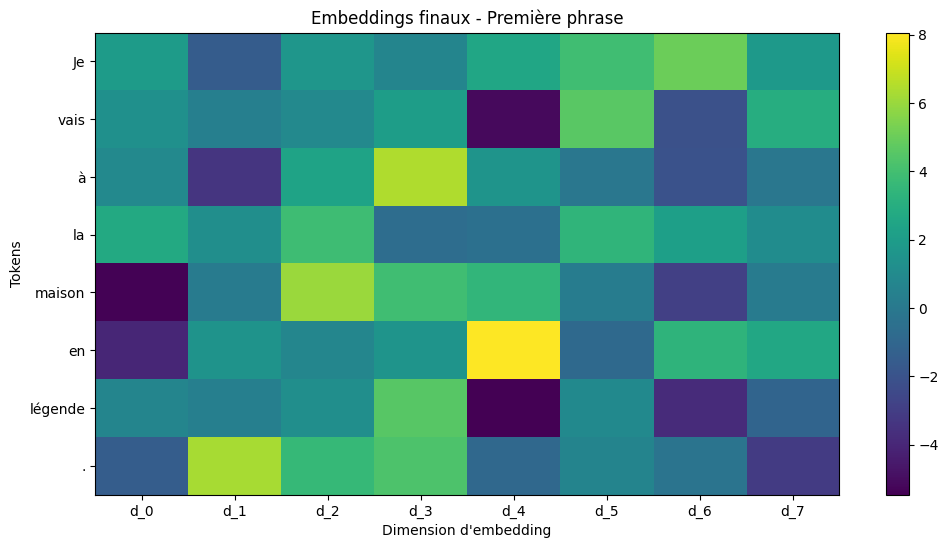

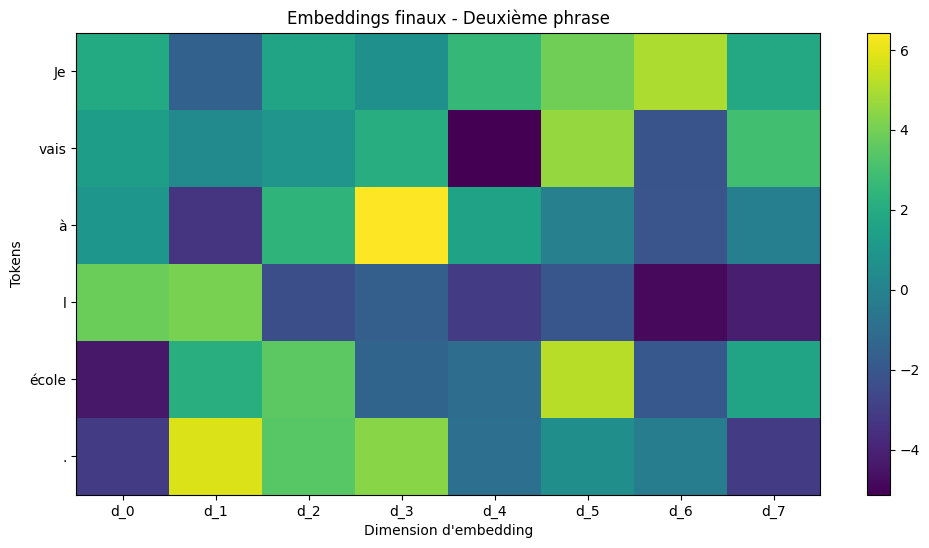

In [19]:
# Première phrase
first_sentence_emb = final_embeddings[0, :len(sentences[0]), :]
plot_embeddings(
    first_sentence_emb,
    "Embeddings finaux - Première phrase",
    sentences[0]
)

# Deuxième phrase
second_sentence_emb = final_embeddings[1, :len(sentences[1]), :]
plot_embeddings(
    second_sentence_emb,
    "Embeddings finaux - Deuxième phrase",
    sentences[1]
)

On voit que "Je" "vais" et "à" sont proches dans l'espace vectoriel, ce qui est logique puisqu'ils ont le même embedding et sont à la même position.

L'idée, c'est que le transformer saura rapprocher les mots "école" et "maison" puisqu'ils sont à la même position et surtout ont des sens proches. Donc si le dataset d'entraînement contient cette similarité relative, le transformer pourra apprendre à rapprocher ces mots.

Si à l'inverse le dataset d'entraînement semble faire de ces mots des mots opposés en tout, alors ils n'auront jamais d'embedding proche.